In [1]:
import os
import pandas as pd
from models import prep

pd.set_eng_float_format(accuracy=2, use_eng_prefix=True)

df = prep.load_dataset()
df = prep.split_sum_totals(df)
df = prep.feature_extraction(df)
df = prep.remove_obvious_outliers(df)

In [5]:
df["id_lotto"].duplicated().sum()

8193

In [44]:
# forget about the time related features 
df = df.drop(columns=["id_lsf", "sinDayOfYear", "cosDayOfYear",
                      "daysSinceBaseDate"])

In [45]:
for agent in ["id_pa", "id_be"]:
    global_stats = pd.concat([
        df.groupby(agent)["importo"].median().rename(
            agent.strip("id_") + "_global_median"),
        df.groupby(agent)["importo"].std().rename(
            agent.strip("id_") + "_global_std")], axis=1)
    df = df.join(global_stats, on=agent)

# sta cosa è sostituta da median_annual_contract e med_ann_rev


In [46]:
print(prep.abc_cpv_short_names)
print(prep.abc_procedure_short_names)

{33: 'appMed', 45: 'lavori', 85: 'servSani', 79: 'servImpr'}
{1: 'aperta', 26: 'adesione', 4: 'negoziata', 23: 'affidamento'}


In [47]:
# df must be local

df = df[df["cpv"] == 33]
df = df[df["id_scelta_contraente"] == 1]

for agent in ["id_pa", "id_be"]:
    local_stats = pd.concat([
        df.groupby(agent)["importo"].median().rename(
            agent.strip("id_") + "_local_median"),
        df.groupby(agent)["importo"].std().rename(
            agent.strip("id_") + "_local_std")], axis=1)
    df = df.join(local_stats, on=agent)

In [48]:
df[[
    "importo", "pa_local_median", "be_local_median", "pa_med_ann_contr", 
    "be_med_ann_contr", "pa_med_ann_expenditure", "be_med_ann_revenue", 
    "id_scelta_contraente", "cpv", "id_pa", "id_be"]]

,importo,pa_local_median,be_local_median,pa_med_ann_contr,be_med_ann_contr,pa_med_ann_expenditure,be_med_ann_revenue,id_scelta_contraente,cpv,id_pa,id_be
29,340.80k,91.20k,150.90k,4.35k,28.99k,219.52M,13.31M,1,33,2435,93140
733,2.43k,11.96k,2.43k,1.05k,4.68k,101.99M,451.85k,1,33,2997,93221
2292,91.20k,91.20k,150.90k,4.35k,28.99k,219.52M,13.31M,1,33,2435,93140
2924,240.00k,131.80k,150.90k,1.07k,28.99k,93.58M,13.31M,1,33,2998,93140
3205,78.00k,91.20k,78.00k,4.35k,19.76k,219.52M,345.93k,1,33,2435,98771
...,...,...,...,...,...,...,...,...,...,...,...
752446,170.40k,91.20k,46.00k,4.35k,3.50k,219.52M,9.34M,1,33,2435,90072
752469,38.70k,91.20k,150.90k,4.35k,28.99k,219.52M,13.31M,1,33,2435,93140
752777,294.00k,91.20k,150.90k,4.35k,28.99k,219.52M,13.31M,1,33,2435,93140
753849,11.10M,125.65k,251.00k,3.00k,1.42k,171.26M,11.74M,1,33,2469,93008


idea: uni-dimentional clustering within the cpv-procedures clusters

<AxesSubplot:xlabel='importo', ylabel='Density'>

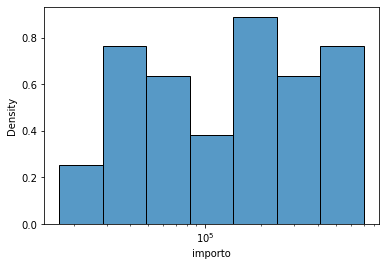

In [58]:
import seaborn as sns
sns.histplot(df[df["id_be"] == 93140].importo, log_scale=True, stat="density")

<AxesSubplot:xlabel='importo', ylabel='Density'>

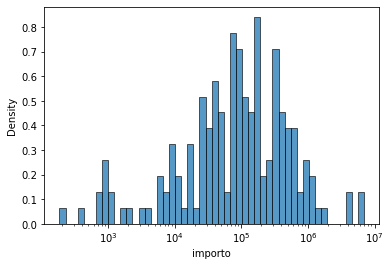

In [51]:
sns.histplot(df[df["id_pa"] == 2435].importo, bins=50, log_scale=True, stat="density")

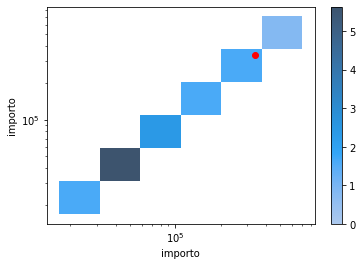

In [54]:
# where lies the lot in the (pa, be) distribution?
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

_, ax = plt.subplots()
sns.histplot(x=df[df["id_pa"] == 2435].importo, 
             y=df[df["id_be"] == 93140].importo, 
             stat="density",log_scale=True, cbar=True, ax=ax)
ax.scatter([340800],[340800], c="red")

# coloro i risultati in funzione della probabilità stimata dalla kde 

In [75]:
from sklearn.neighbors import KernelDensity
# from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from scipy.stats import boxcox
import pandas as pd
import numpy as np
from os import path

directory = "datasets"
dataset = "appMed_aperta"
model = "kde"
X = pd.read_csv(
    path.join(directory, dataset + ".csv"), index_col="id_lotto")

# remove time related features
X = X.drop(columns=["sinDayOfYear", "cosDayOfYear", "daysSinceBaseDate"])
# remove median contract pa and median contract be as they are computed
# on whole dataset, not only the CPV and award procedure
X = X.drop(columns=["median_contract_pa", "median_contract_be"])

# preprocessing
col_names = X.columns
X.duration = X.duration.replace(0, X.duration.median())
scaler = RobustScaler(with_centering=False)
table = scaler.fit_transform(X)
# scale only the real-valued columns
for i in range(0, 2):
    table[:, i], _ = boxcox(table[:, i])

# already optimized bandwidth
bandwidth = 0.26366508987303583
kde = KernelDensity(bandwidth=1, kernel="gaussian")
kde.fit(table)



In [76]:
scores = kde.score_samples(table)

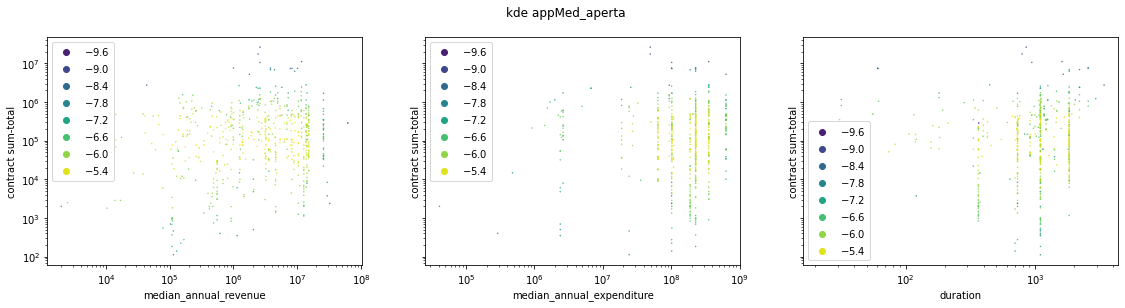

In [77]:
fig, ax = plt.subplots(1, 3, figsize=(6.4*3, 4.2), sharey=True)
fig.suptitle(model + " " + dataset)
for i, feature in enumerate(["median_annual_revenue",
                            "median_annual_expenditure", "duration"]):
    s = ax[i].scatter(x=X[feature], y=X.sum_total, c=scores, alpha=1, s=.2)
    ax[i].legend(*s.legend_elements())
    ax[i].set_ylabel("contract sum-total")
    ax[i].set_xlabel(feature)
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")

In [88]:
for thr in np.linspace(np.min(scores), np.max(scores), 10):
    # samples below threshold
    outliers_total = np.sum(scores < thr)
    print(f"thr {thr:.2f} yields {outliers_total} outliers")

thr -10.05 yields 0 outliers
thr -9.51 yields 1 outliers
thr -8.97 yields 2 outliers
thr -8.43 yields 5 outliers
thr -7.88 yields 14 outliers
thr -7.34 yields 31 outliers
thr -6.80 yields 62 outliers
thr -6.25 yields 153 outliers
thr -5.71 yields 320 outliers
thr -5.17 yields 608 outliers
